# 1) Ingrese su Nombre y Número de alumno/a

(1 Punto)

In [123]:
Nombre = 'Renzo Guerrero'
ID     = '12345678K'
print('IMPORTANTE: Cambie el nombre del archivo (arriba-izquierda) por '+ID+'.ipynb')

IMPORTANTE: Cambie el nombre del archivo (arriba-izquierda) por 12345678K.ipynb


# 2) Importe las Librerías

(1 Punto)

*Todas las librerías de este código deben ir en esta celda. Sólo está permitido usar las librerías de los ejemplos vistos en clase.*



In [141]:
import numpy as np
import matplotlib.pylab as plt
import os
from cv2 import imread, IMREAD_GRAYSCALE,cvtColor
import cv2
os.chdir(r"C:\Users\titos\Github\Procesamiento Imagenes\Cap15_Geometría\imagenes")

# 3) Corrección de Perspectiva

(5 Puntos)

Para la siguiente imagen, corrija la perspectiva de tal forma que el borde del reloj sea un círculo

`https://www.dropbox.com/s/3wfcumi4voi4ht0/clock.png`



size =  (756, 1008)


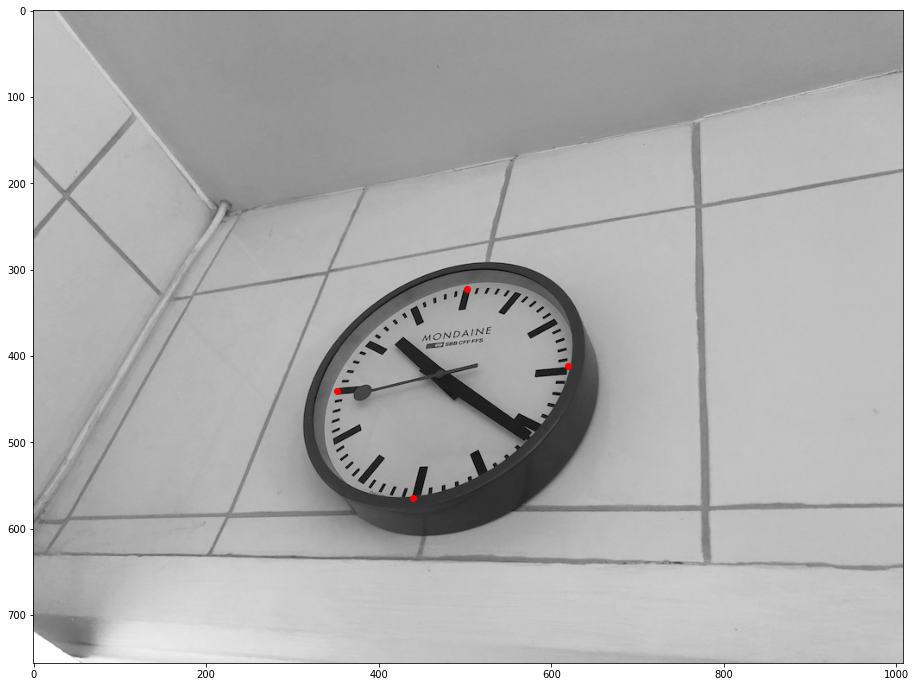

In [2]:
clock = imread('clock.png',0)
# Coordenadas de las 12, 3, 6 y 9 (mp = m')
xp = np.array([502,620,440,352])  # buscadas manualmente
yp = np.array([322,412,565,440])  # buscadas manualmente
i = np.array([0,1,3,2,0])
print('size = ',clock.shape)
plt.figure(figsize=(18,12))
plt.imshow(clock,cmap='gray')
plt.scatter(xp,yp,c='red')
plt.show()

In [9]:
# Corner coordinates of transformed images (m)
# Coordenadas ideales del reloj, pertenecen a un circulo de radio r centrado en (q,q)
q = 400
r = 300
x = np.array([q,q+r,q,q-r])
y = np.array([q-r,q,q+r,q])

In [10]:
(N,M) = clock.shape
def homography(X,H):
    Hinv  = np.linalg.inv(H)
    Xp    = np.zeros((N,M),np.uint8)

    m = np.ones((N*M,3))
    t = 0
    for i in range(N):
        for j in range(M):
            m[t,0:2] = [j,i]
            t = t+1

    mph = np.dot(Hinv,m.T)  # Transformation m to mp
    mp  = np.divide(mph[0:2,:],mph[2,:])
    mpf = np.fix(mp).astype(int)

    ip = mpf[1,:]
    jp = mpf[0,:]
    ktj = np.logical_and(jp>=0,jp<M)
    kti = np.logical_and(ip>=0,ip<N)
    kt  = np.logical_and(kti,ktj)

    t = 0
    for i in range(N):
        for j in range(M):
            if kt[t]:
                Xp[i,j] = X[ip[t],jp[t]]
            t = t+1
    return Xp

In [6]:
# Estimation of H: mp = H*m

def homography_matrix(m,mp):
    (x ,y ) = m
    (xp,yp) = mp
    n       = len(x)
    A       = np.zeros((2*n,9))
    for i in range(n):
        j = i*2
        A[j  ,:] = [x[i], y[i], 1, 0, 0, 0, -x[i]*xp[i], -y[i]*xp[i], -xp[i]]
        A[j+1,:] = [0,0,0,x[i],y[i],1,-x[i]*yp[i], -y[i]*yp[i], -yp[i]]
        [U,S,V] = np.linalg.svd(A)
        h       = V[-1,:]
        H       = np.vstack([h[0:3], h[3:6], h[6:9]])
    return H

In [11]:
print('mp  = ', (xp,yp))
print('m   = ', (x,y))

mm = np.vstack([x, y, np.array([1, 1, 1, 1])])
H2 = homography_matrix((x,y),(xp,yp))
mmp = np.dot(H2,mm)
mmp = mmp/mmp[-1,:]

print('Estimacion de mp a partir de m:')
print('mps = ', (mmp[0,:],mmp[1,:]))

mp  =  (array([502, 620, 440, 352]), array([322, 412, 565, 440]))
m   =  (array([400, 700, 400, 100]), array([100, 400, 700, 400]))
Estimacion de mp a partir de m:
mps =  (array([502., 620., 440., 352.]), array([322., 412., 565., 440.]))


Imagen izquierda: Transformada                       | Imagen derecha: Original


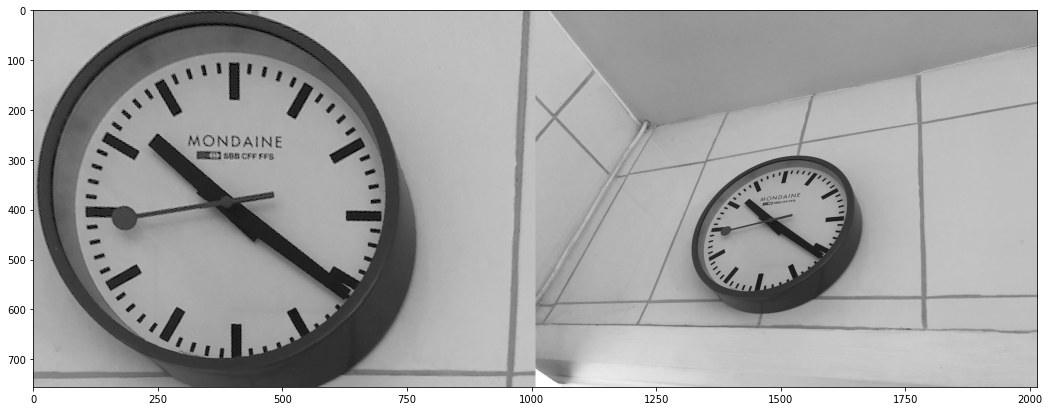

In [12]:
Hinv  = np.linalg.inv(H2)

Y = homography(clock,Hinv)
Z = np.concatenate((Y,clock),axis=1)

print('Imagen izquierda: Transformada                       | Imagen derecha: Original')
plt.figure(figsize=(18,24))
plt.imshow(Z,cmap='gray')
plt.show()

# 4) Proyección en Perspectiva 3D -> 2D


Una pirámide definido como 5 puntos ${\bf p}_i$ en el sistema de coordenadas $(X_i',Y_i',Z_i')$ con los valores:

$p_1 = (0, 0, 0)$

$p_2 = (2, 0, 0)$

$p_3 = (2, 2, 0)$

$p_4 = (0, 2, 0)$

$p_5 = (1, 1, 2)$

(los primeros 4 puntos son de la base horizontal cuadrada de la pirámide, el último punto es el vértice superior)




## 4.1) Definición de coordenadas homogéneas

(0.5 puntos)

Defina una matriz Mp de 4x5 elementos que defina los 5 puntos de la pirámide en coordenadas homogéneas en el sistema $(X_i',Y_i',Z_i')$. Es decir, los 5 puntos se deben almacenar en la variable Mp de 4x5 elementos, donde cada columna debe ser $(X'_i,Y'_i,Z'_i,1)$.


In [13]:
Mp = np.array([[0,0,0,1],[2,0,0,1],[2,2,0,1],[0,2,0,1],[1,1,2,1]])
Mp = Mp.T
print('shape:',Mp.shape)
print(Mp)

shape: (4, 5)
[[0 2 2 0 1]
 [0 0 2 2 1]
 [0 0 0 0 2]
 [1 1 1 1 1]]


## 4.2) Transformación 3D -> 3D 

(1 punto)

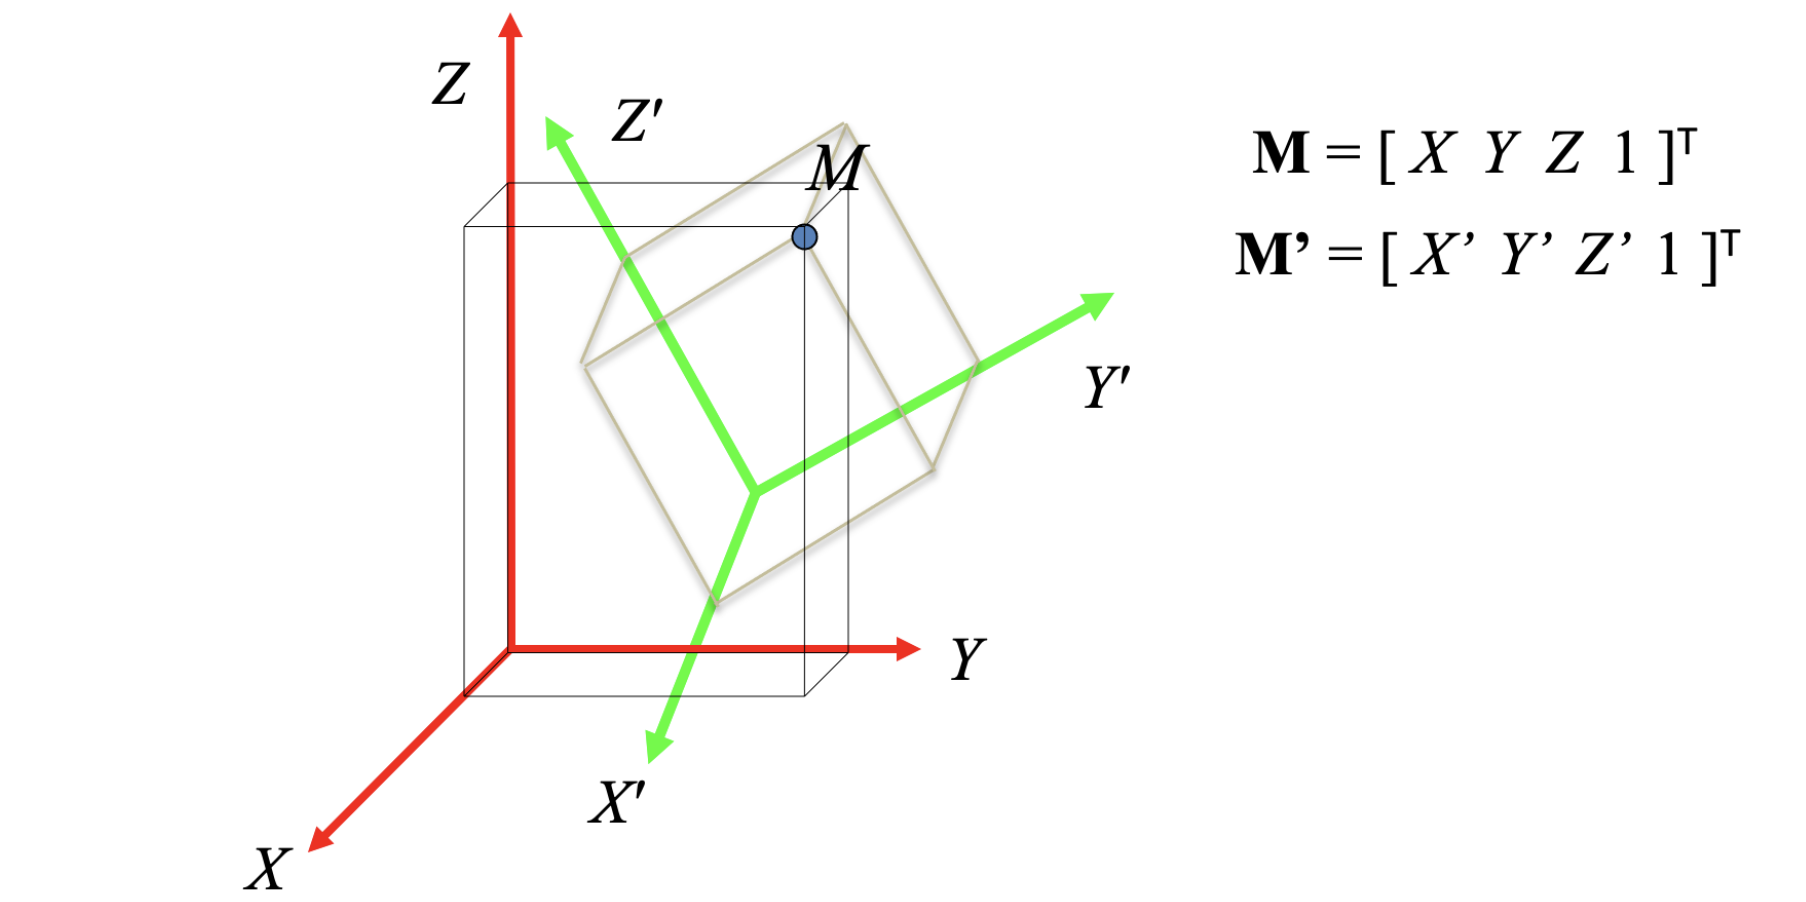

Transforme los puntos de Mp con una transformación Euclideana cuya traslación y rotación son:

* tx = 10

* ty = 20

* tz = 400

* wx = 20 grados

* wy = 30 grados

* wz = 45 grados

Esta transformación es de un sistema de coordenadas $(X',Y',Z')$ a un sistema de coordenadas $(X,Y,Z)$.

Los 5 puntos transformados se deben almacenar en la variable M de 4x5 elementos, donde cada columna debe ser $(X_i,Y_i,Z_i,1)$.



In [90]:
def rotation_matrix_3d(wx, wy, wz):
    R = np.array([
            [ np.cos(wy) * np.cos(wz), -np.cos(wy) * np.sin(wz),  np.sin(wy)],
            [ np.sin(wx) * np.sin(wy) * np.cos(wz) + np.cos(wx) * np.sin(wz),
             -np.sin(wx) * np.sin(wy) * np.sin(wz) + np.cos(wx) * np.cos(wz),
             -np.sin(wx) * np.cos(wy)],
            [-np.cos(wx) * np.sin(wy) * np.cos(wz) + np.sin(wx) * np.sin(wz),
              np.cos(wx) * np.sin(wy) * np.sin(wz) + np.sin(wx) * np.cos(wz),
              np.cos(wx) * np.cos(wy)]
      ])
    return R

In [105]:
# Rotaciones
wx = (20 / 180.0) * np.pi #Rotation in radians
wy = (30 / 180.0) * np.pi #Rotation in radians
wz = (45.0 / 180.0) * np.pi #Rotation in radians

# Translation tx,ty,tz in cm
t = np.array([10.0, 20.0, 400.0])
t = t.reshape((3,1))

# Generate the rotation matrix R
R = rotation_matrix_3d(wx,wy,wz) 

# Euclidean transformation matrix H = [R t; 0 0 1]
H = np.hstack([R, t])  
H = np.vstack([H, np.array([0, 0, 0, 1])])
print("Vector de traslación:",t)
print("Matriz de rotación R:",R)
print("Matriz euclidiana de transformación:",H)

Vector de traslación: [[ 10.]
 [ 20.]
 [400.]]
Matriz de rotación R: [[ 0.61237244 -0.61237244  0.5       ]
 [ 0.78538541  0.54354064 -0.29619813]
 [-0.09038675  0.57407627  0.81379768]]
Matriz euclidiana de transformación: [[ 6.12372436e-01 -6.12372436e-01  5.00000000e-01  1.00000000e+01]
 [ 7.85385406e-01  5.43540643e-01 -2.96198133e-01  2.00000000e+01]
 [-9.03867495e-02  5.74076275e-01  8.13797681e-01  4.00000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [109]:
M = np.dot(H, Mp)  # Transformation m to mp
print("Matriz M:",M)
print("Tamaño de la matriz M:",M.shape)

Matriz M: [[ 10.          11.22474487  10.           8.77525513  11.        ]
 [ 20.          21.57077081  22.6578521   21.08708129  20.73652978]
 [400.         399.8192265  400.96737905 401.14815255 402.11128489]
 [  1.           1.           1.           1.           1.        ]]
Tamaño de la matriz M: (4, 5)


## 4.3) Transformación 3D -> 2D

(1 punto)

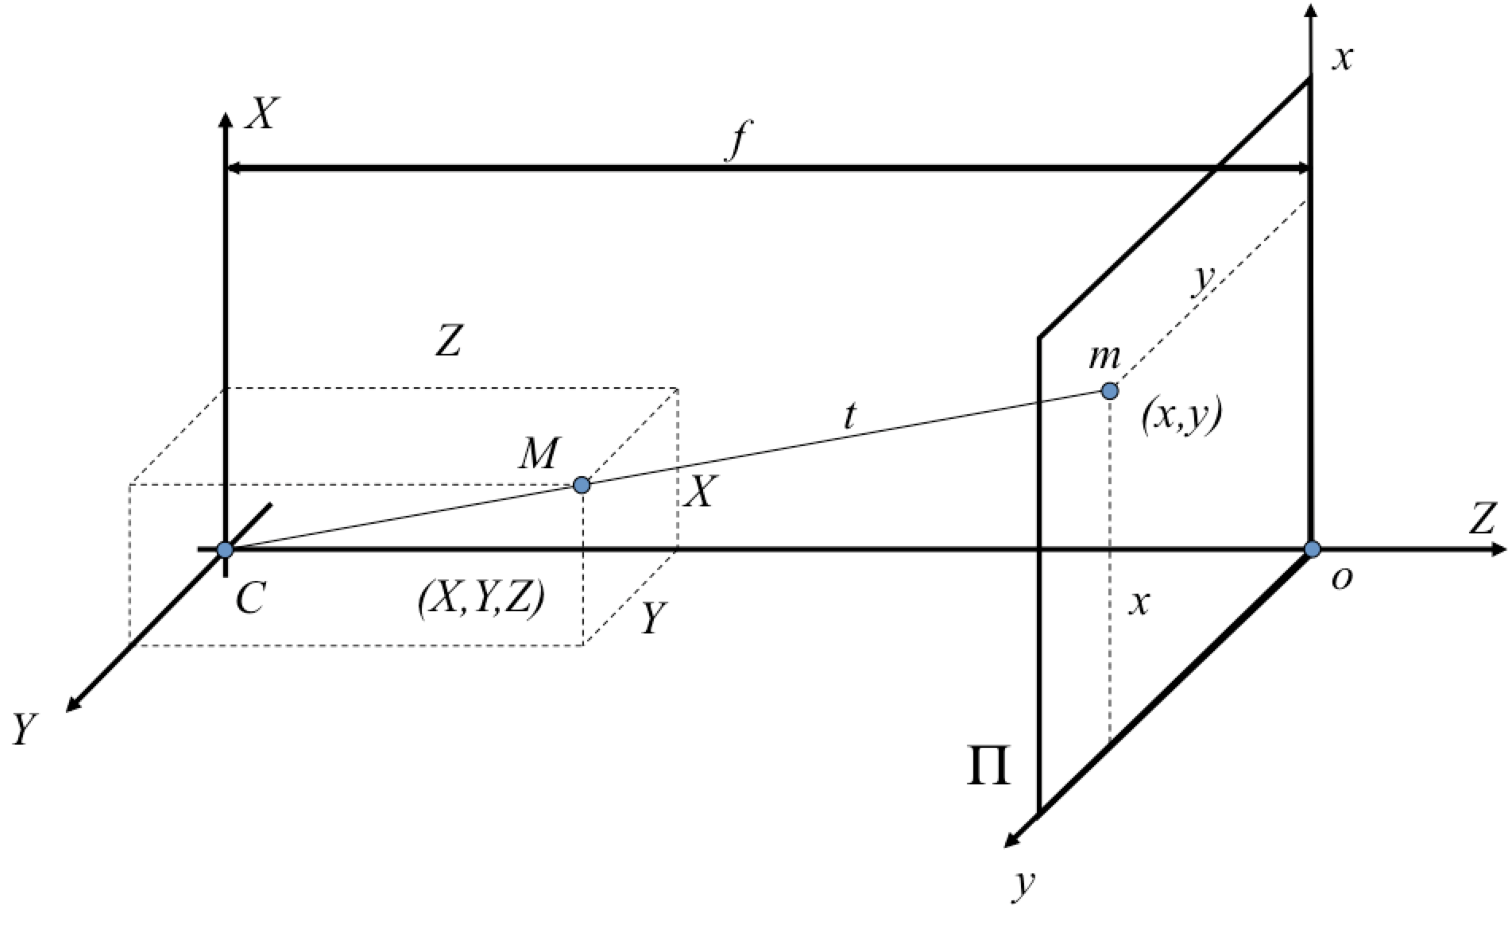

Proyecte los 5 puntos de M, que están en coordenadas $(X,Y,Z)$ a un plano de proyección $(x,y)$ que se encuentra perpendicular al eje $Z$ a una distancia focal $f = 1000$. Los 5 puntos transformados se deben almacenar en la variable m de 3x5 elementos, donde cada columna debe ser $(x_i,y_i,1)$.

In [110]:
def perspective_matrix(f):
    P = np.array([
        [f, 0, 0, 0],
        [0, f, 0, 0],
        [0, 0, 1, 0]
    ])
    return P

In [112]:
f = 1000  # Focal distance in cm

P = perspective_matrix(f)  # Create the projection matrix P

m = np.dot(P, M)  # Transformation M to m
m = m / m[-1]  # Homogeneous coordinates requires to be normalized by the matrix element (3, 1)

print("Punto bidimensional en corrdenadas homogeneas:",m)

Punto bidimensional en corrdenadas homogeneas: [[25.         28.07455002 24.93968468 21.87534723 27.35561128]
 [50.         53.95130945 56.50796868 52.5668164  51.56913164]
 [ 1.          1.          1.          1.          1.        ]]


## 4.4) Transformación 2D -> 2D

(1 punto)

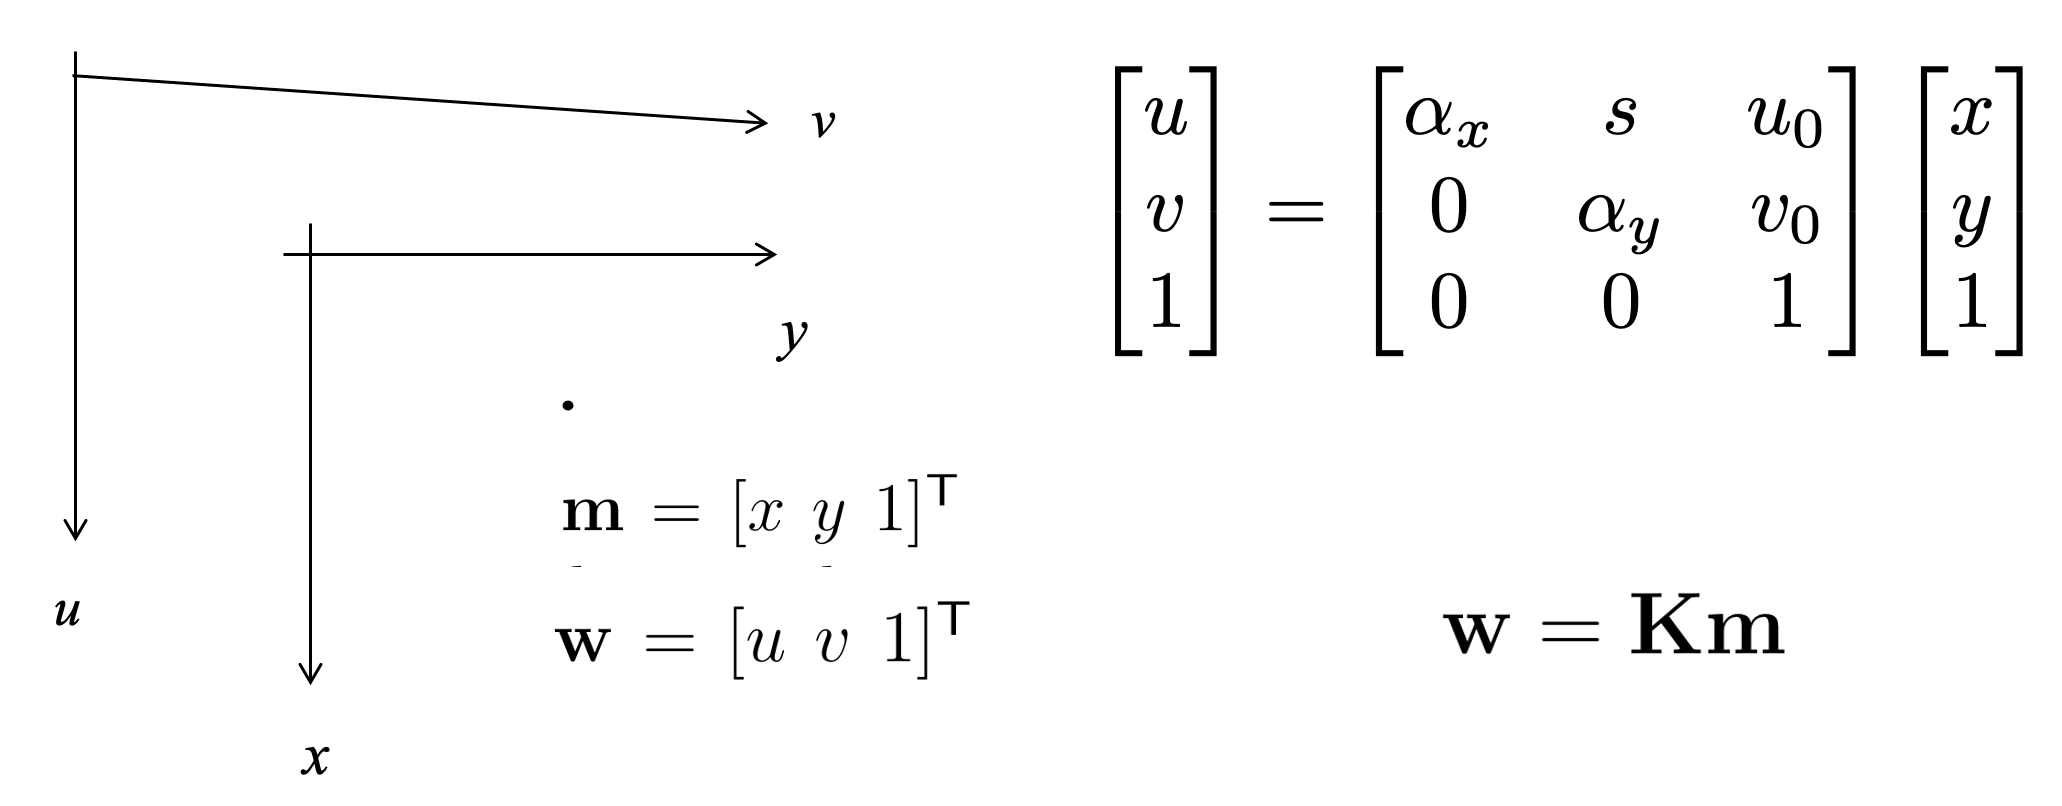



Transforme los 5 puntos del sistema de coordenas $(x,y)$ a las coordenadas de la imagen $(u,v)$ usando la ecuación ${\bf w} = {\bf Km}$ mostrada en la figura. Los elementos de ${\bf K}$ son:

* $\alpha_x = \alpha_y = 3.1$

* $s=0.05$

* $u_0 = 110$

* $v_0 = 235$

Los 5 puntos transformados se deben almacenar en la variable w de 3x5 elementos, donde cada columna debe ser $(u_i,v_i,1)$.


In [113]:
K = np.array([[3.1,0.05,110],[0,3.1,235],[0,0,1]])
w = np.dot(K,m)
print("Vector en pixeles:",w)

Vector en pixeles: [[190.         199.72867052 190.13842094 180.44191724 197.38085154]
 [390.         402.24905928 410.17470291 397.95713085 394.86430808]
 [  1.           1.           1.           1.           1.        ]]


## 4.5 Transformación total 3D -> 2D

(0.5 puntos)

Encuentre la matriz ${\bf A}$ tal que realice la transformación de $(X',Y',Z')$ a $(u,v)$, es decir que cumpla esta ecuación:

$\lambda {\bf w} = {\bf A}{\bf M}'$.

Para verificar que la matriz ${\bf A}$ esté correcta, realice la multiplicación de A por la matriz Mp y encuentre w. El resultado debe ser exactamente el mismo del paso anterior.

In [115]:
A = np.dot(K,P)
A = np.dot(A,H)
w = np.dot(A,Mp)
w = w/w[-1]
print("Matriz A:",A)
print("Vector w:",w)

Matriz A: [[ 1.92768128e+03 -1.80802913e+03  1.62470784e+03  7.60000000e+04]
 [ 2.41345387e+03  1.81988392e+03 -7.26971756e+02  1.56000000e+05]
 [-9.03867495e-02  5.74076275e-01  8.13797681e-01  4.00000000e+02]]
Vector w: [[190.         199.72867052 190.13842094 180.44191724 197.38085154]
 [390.         402.24905928 410.17470291 397.95713085 394.86430808]
 [  1.           1.           1.           1.           1.        ]]


## 4.6) Grafica

(1 punto)

Grafique la pirámide proyecta en las coordenadas $(u,v)$. En esta gráfica deben estar tanto los vértices como las líneas que unen los vértices de la pirámide.

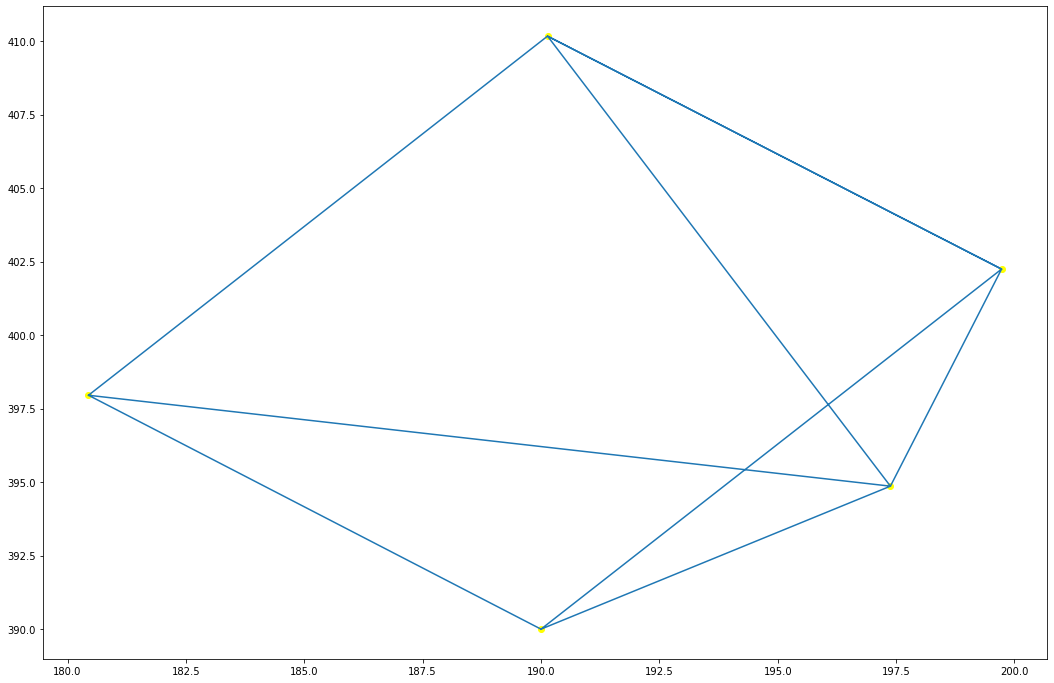

In [122]:
u = w[0,:]
v = w[1,:]

s = np.array([0, 1, 4, 0, 3, 4, 2, 1, 2, 3])

plt.figure(figsize=(18,12))
plt.plot(u[s],v[s])
plt.scatter(u,v,c='yellow')
plt.show()

# 5) Reconstrucción 3D

(4 puntos)

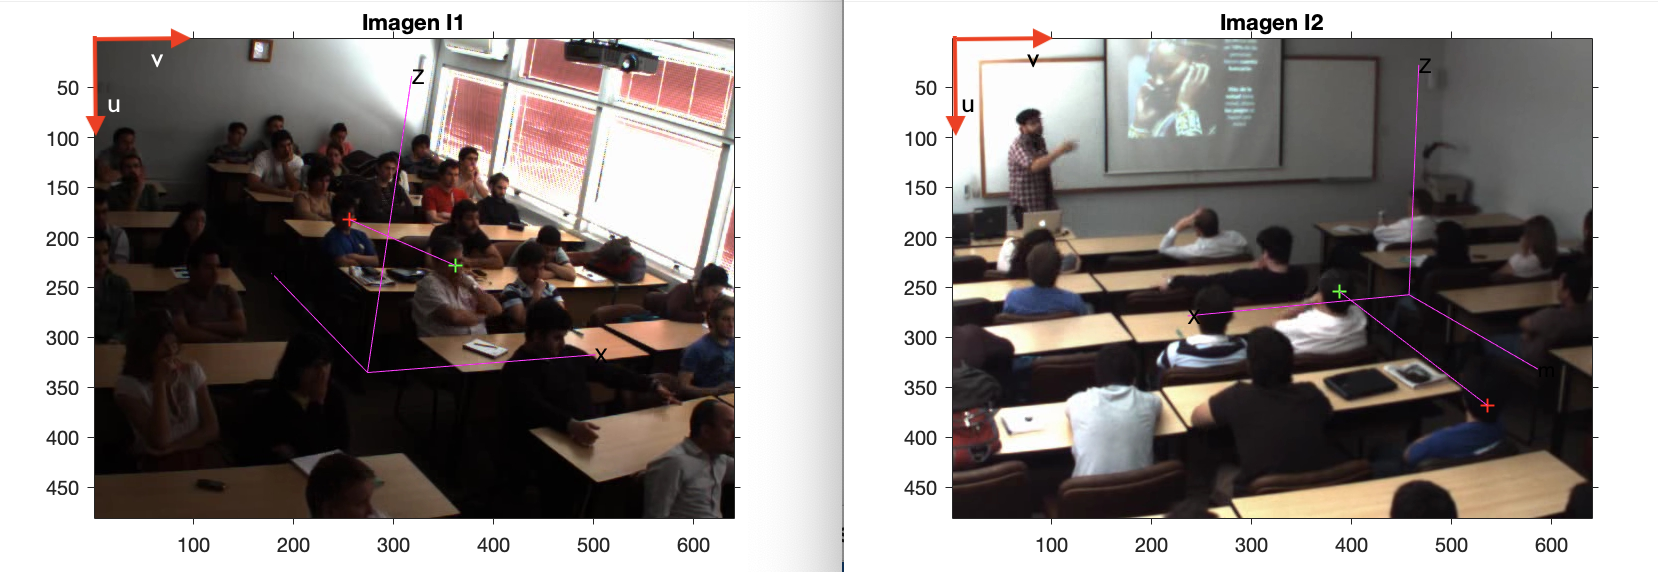

Encuentre la distancia en milímetros entre los centros de las cabezas de las personas marcadas en la figura (con cruces rojas y verdes).

Para esto dispone de:

1) Las dos imágenes:

* Imagen I1: `https://www.dropbox.com/s/0ox79fyvcmduu5u/I1.jpg`

* Imagen I2: `https://www.dropbox.com/s/6ozy142a5lzqvdj/I2.jpg`

2) Las dos mátrices de proyección P1 y P2 que relacionan las coordenadas de la sala de clases (X,Y,Z) (en mímiletros) con las coordenadas de la imagen (u,v) (en pixeles) para las imágenes I1 e I2 respectivamente:

* Matriz P1: `https://www.dropbox.com/s/3zzms94us5d37nj/P1.npy`

* Matriz P2: `https://www.dropbox.com/s/rdkiv4someisnbn/P2.npy`






In [164]:
# Function extracted from library pyxvis, written by Christian Pieringer, Domingo Mery
def recon_3dn(m, mat_p, method=None):
    """
    This method computes the reconstruction of a M point from two dimensional
    points in images.

    Args:
        m:
        mat_p:
        method:
        ls: the function computes the reconstruction using least-square method
    
    Returns:
        mat_mr: Reprojected points
        ms: Estimated points in 2D
        err: reprojection error in pixels
    """

    n = m.shape[-1]

    mat_q = np.zeros((2 * n, 3))
    mat_r = np.zeros((2 * n, 1))

    for k in range(n):
        x = m[0, k] / m[2, k]
        y = m[1, k] / m[2, k]
        p = mat_p[k * 3:k * 3 + 3, :]
        mat_q[k * 2:k * 2 + 2, :] = np.array(
            [
                [p[2, 0] * x - p[0, 0], p[2, 1] * x - p[0, 1],
                 p[2, 2] * x - p[0, 2]],
                [p[2, 0] * y - p[1, 0], p[2, 1] * y - p[1, 1],
                 p[2, 2] * y - p[1, 2]]
            ]
        )

        mat_r[k * 2:k * 2 + 2, :] = np.array(
            [
                [p[0, 3] - p[2, 3] * x],
                [p[1, 3] - p[2, 3] * y]
            ]
        )

    mat_mr = np.vstack([np.dot(np.linalg.pinv(mat_q), mat_r), 1.0])  # Compute [Q.T * Q] * Q.T as pseudoinverse
    
    ms = mat_p @ mat_mr
    ms = np.reshape(ms, (n, 3)).T
    ms = ms / ms[-1, :]
    d = ms[0:1, :] - m[0:1, :]
    err = np.sqrt(np.sum(d * d, 1)).item()

    return mat_mr, ms, err

In [165]:
P1 = np.load ('matrices/P1.npy')
P2 = np.load('matrices/P2.npy')
P = np.vstack([P1, P2])
I1 = cvtColor(imread('I1.jpg'),cv2.COLOR_BGR2RGB)
I2 = cvtColor(imread('I2.jpg'),cv2.COLOR_BGR2RGB)
print("Matriz P1:",P1)
print("Matriz P2:",P2)
print("Matriz P:",P)

Matriz P1: [[ 9.28755039e+02 -1.41432599e+02  3.95426739e+01  1.23163726e+06]
 [ 1.01854664e+02 -1.04792471e+02 -8.99627026e+02  1.50616954e+06]
 [ 4.89139000e-01  8.21956000e-01 -2.91772000e-01  4.49538771e+03]]
Matriz P2: [[-1.05230945e+03  3.53755637e+01 -6.29924692e+01  2.98012482e+06]
 [-1.63696039e+01  2.67208014e+01 -1.00426038e+03  1.67543652e+06]
 [-3.87935000e-01 -8.93812000e-01 -2.24958000e-01  6.51301923e+03]]
Matriz P: [[ 9.28755039e+02 -1.41432599e+02  3.95426739e+01  1.23163726e+06]
 [ 1.01854664e+02 -1.04792471e+02 -8.99627026e+02  1.50616954e+06]
 [ 4.89139000e-01  8.21956000e-01 -2.91772000e-01  4.49538771e+03]
 [-1.05230945e+03  3.53755637e+01 -6.29924692e+01  2.98012482e+06]
 [-1.63696039e+01  2.67208014e+01 -1.00426038e+03  1.67543652e+06]
 [-3.87935000e-01 -8.93812000e-01 -2.24958000e-01  6.51301923e+03]]


In [166]:
# Los puntos son en la imagen de los centros de sus cabezas (marcadas manualmente son):
mg1 = np.array([362.0,228.0,1]).reshape(3,1) # Persona g en Imagen 1
mg2 = np.array([388.0,254.0,1]).reshape(3,1) # Persona g en Imagen 2
mr1 = np.array([256.0,182.0,1]).reshape(3,1) # Persona r en Imagen 1
mr2 = np.array([536.0,368.0,1]).reshape(3,1) # Persona r en Imagen 2

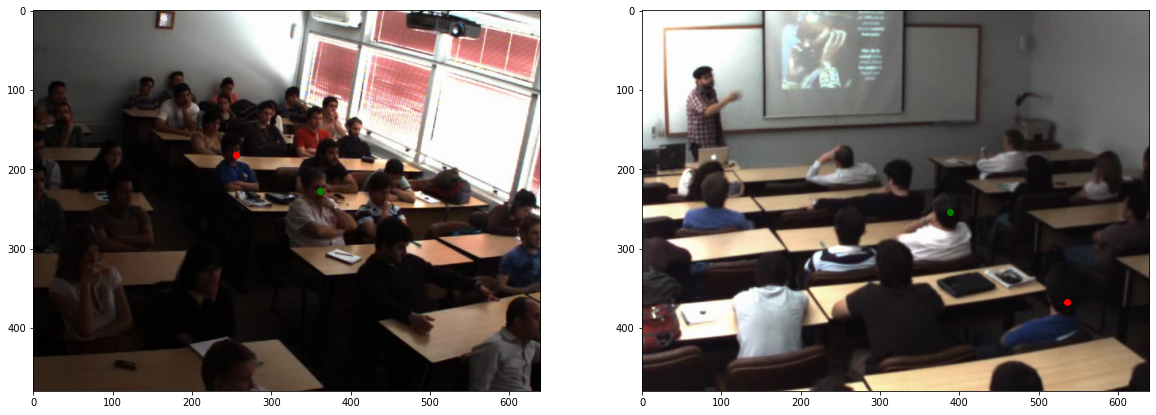

In [167]:
plt.figure(1,figsize=(20,18))
plt.subplot(1,2,1)
plt.imshow(I1,cmap='gray')
plt.scatter(mg1[0],mg1[1],c='green')
plt.scatter(mr1[0],mr1[1],c='red')
plt.subplot(1,2,2)
plt.imshow(I2,cmap='gray')
plt.scatter(mg2[0],mg2[1],c='green')
plt.scatter(mr2[0],mr2[1],c='red')
plt.show()

In [187]:
# 3D reprojection
mg = np.hstack([mg1, mg2])  # First 2D point in each view
mr = np.hstack([mr1, mr2]) # Second 2D point in each view
print(mg)
print(mr)

[[362. 388.]
 [228. 254.]
 [  1.   1.]]
[[256. 536.]
 [182. 368.]
 [  1.   1.]]


In [188]:
Mg, d1, err1 = recon_3dn(mg, P)  # 3D reconstruction of first point
Mr, d2, err2 = recon_3dn(mr, P)  # 3D reconstruction of second point

In [189]:
# Distancia Euclideana
d = np.linalg.norm(Mg[0:3]-Mr[0:3])
print('distancia = ',d,'mm')

distancia =  1481.3325668014047 mm
